# 3.2 线性回归的从零开始实现

In [3]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__)

1.11.0


## 3.2.1 生成数据集

In [4]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs,
                      dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

In [5]:
print(features[0], labels[0])


tensor([ 0.9470, -0.1706]) tensor(6.6571)


/var/folders/bw/x91h171j52b1hw8pvt0f62_00000gn/T/ipykernel_58759/2539917512.py:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


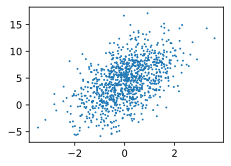

In [9]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

# set_figsize()
display.set_matplotlib_formats('svg')
figsize=(3.5, 2.5)
plt.rcParams['figure.figsize'] = figsize
plt.scatter(features[:, 0].numpy(), labels.numpy(), 1)

## 3.2.2 读取数据

In [12]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j) #一维数组以列向量为数学计算约定，以行向量为表现形式

In [15]:
xx=data_iter(10, features, labels)
next(xx) # or next(iter(xx))


(tensor([[ 1.2111,  0.6739],
         [-1.6988, -0.0362],
         [-0.8801, -1.2460],
         [-2.0103,  1.6792],
         [ 0.7788, -0.2543],
         [ 0.2531,  0.5390],
         [-0.1421,  0.4049],
         [ 0.7600, -1.2953],
         [ 0.0642, -0.7097],
         [-0.4336, -0.7001]]),
 tensor([ 4.3174,  0.9055,  6.6669, -5.5263,  6.6218,  2.8839,  2.5491, 10.1074,
          6.7324,  5.7183]))

In [16]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.6951,  1.0406],
        [-1.1679,  0.9536],
        [-0.4824, -0.8930],
        [ 1.7458,  0.7292],
        [-1.0442,  0.7886],
        [-0.6134, -0.8565],
        [-0.1708,  0.5704],
        [-0.5565,  0.1174],
        [-0.5915, -2.5042],
        [ 1.3478, -0.7908]]) 
 tensor([-0.7493, -1.3872,  6.2655,  5.2082, -0.5720,  5.8761,  1.9118,  2.6701,
        11.5126,  9.5930])


## 3.2.3 初始化模型参数

In [17]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)


In [18]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

## 3.2.4 定义模型

In [62]:
def linreg(X, w, b):  # 本函数已保存在d2lzh包中方便以后使用
    return torch.mm(X, w) + b

## 3.2.5 定义损失函数

In [63]:
def squared_loss(y_hat, y):  # 本函数已保存在pytorch_d2lzh包中方便以后使用
    return (y_hat - y.view(y_hat.size())) ** 2 / 2 #？？？？？？？？？？？？？？？？？？？？？

## 3.2.6 定义优化算法

In [64]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

## 3.2.7 训练模型

In [66]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
        
        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.000049
epoch 2, loss 0.000049
epoch 3, loss 0.000049


In [67]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9999],
        [-3.4001]], requires_grad=True)
4.2 
 tensor([4.1993], requires_grad=True)
